# Task 2.4 - Concentric sampled deformation gradients

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from keras import optimizers
from keras import losses

from src.models import CustomFFNN, TransIsoInvariantsICNN
from src.data_import import load_train_test_concentric, get_naive_dataset, get_pann_dataset
from src.plots import plot_stress_predictions, plot_energy_prediction, plot_loss
from src.analytic_potential import get_C_features
from src.predict_utils import predict_multi_cases_PANN, predict_multi_cases_naive
from src.utils import get_scores
from src.plot_and_predict import predict_and_plot_naive_model, predict_and_plot_pann_model

2024-12-15 19:26:51.679924: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 19:26:51.684597: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 19:26:51.696796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 19:26:51.717300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 19:26:51.722846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 19:26:51.738687: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
data_dir = os.path.abspath('concentric')

In [3]:
def reached_good_prediction(labels: dict[str, np.ndarray], predictions: dict[str, np.ndarray], threshold: float = 7.0) -> bool:
    scores = get_scores(labels, predictions, 'rmse', use_total=True)
    print(f'Score: {max(list(scores.values()))}')
    return all(abs(val < threshold) for val in scores.values())

## Naive NN calibration on stress $P$

In [4]:
def train_naive_model(train_F: tf.Tensor, train_P: tf.Tensor, name: str) -> CustomFFNN:
    naive_features ,naive_labels = get_naive_dataset((train_F, train_P, None))

    naive_model = CustomFFNN(
        hidden_sizes=[32, 32, 32, 9],
        activations=['softplus', 'softplus', 'softplus', 'linear']
    )
    naive_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.MeanSquaredError()
    )
    naive_h = naive_model.fit(naive_features, naive_labels, batch_size=16, epochs=1000, verbose=0)
    naive_loss = naive_h.history['loss']
    plot_loss(naive_loss, suptitle=name)
    return naive_model

## PANN calibration on stress $P$ and energy $W$

In [5]:
def train_pann_model(train_F: tf.Tensor, train_P: tf.Tensor, train_W: tf.Tensor, name: str) -> TransIsoInvariantsICNN:
    pann_features, pann_labels = get_pann_dataset((train_F, train_P, train_W), 'WP')

    pann_model = TransIsoInvariantsICNN(
        hidden_sizes=[16, 1],
        activations=['softplus', 'linear'],
        use_output_and_derivative=True
    )
    pann_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.MeanSquaredError()
    )
    pann_h = pann_model.fit(pann_features, pann_labels, batch_size=32, epochs=1000, verbose=0)
    pann_loss = pann_h.history['loss']
    plot_loss(pann_loss, suptitle=name)
    return pann_model

## Load Datasets, calibrate and predict both models

Test size of 95.0%
Naive Model...


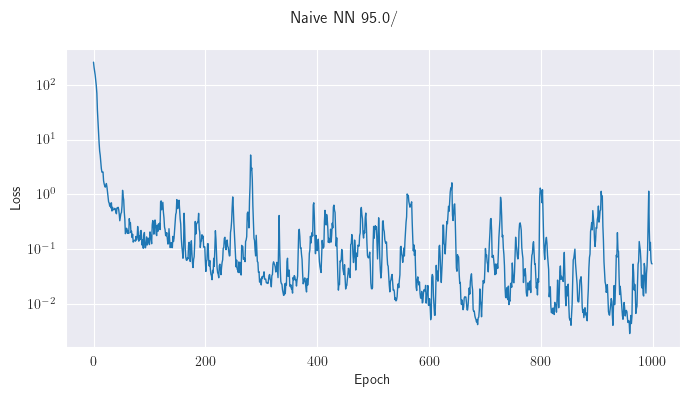

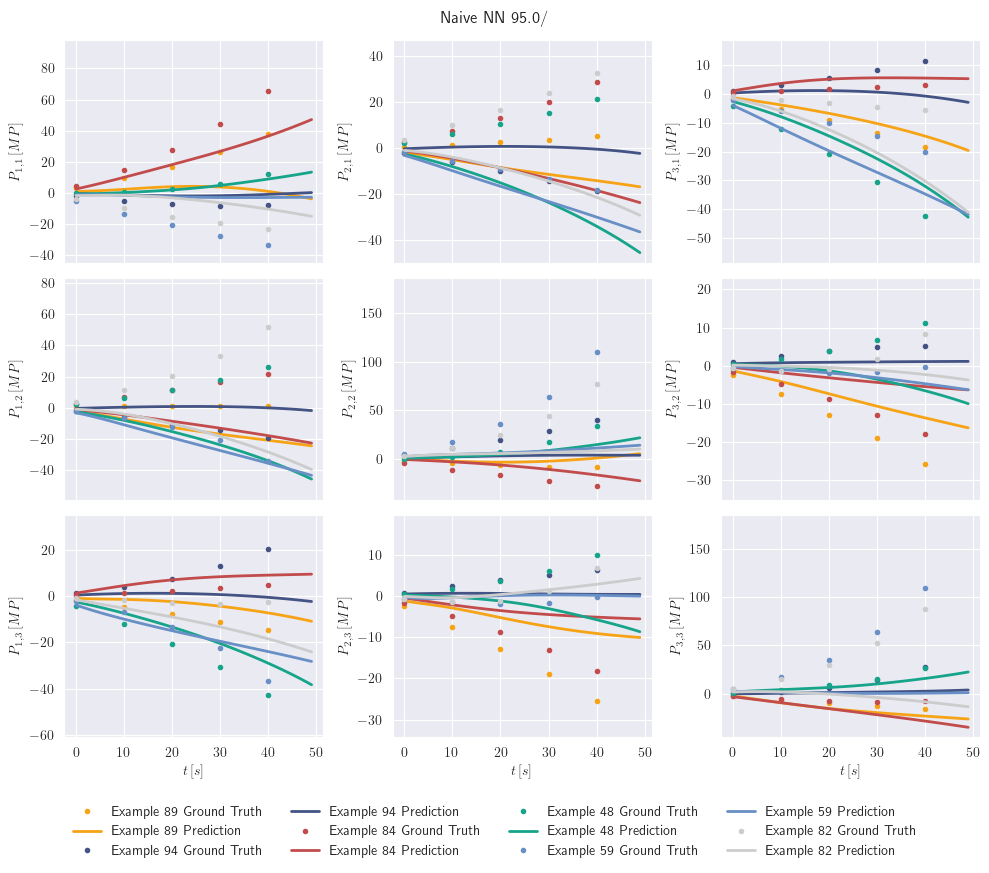

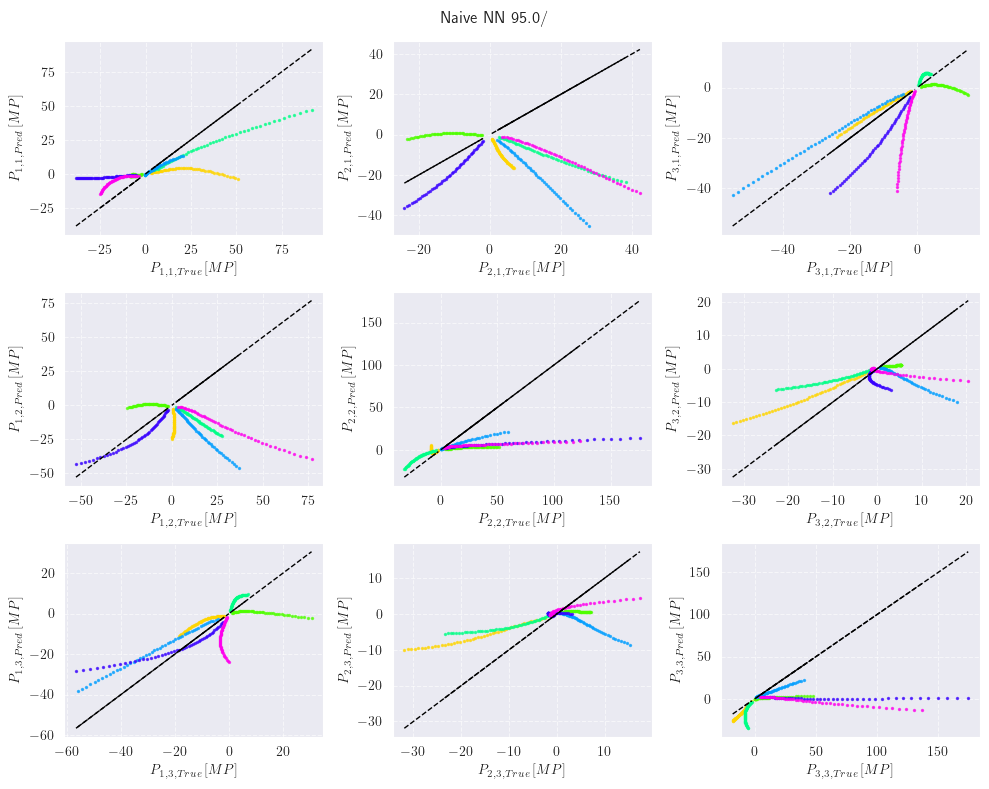

Score: 36.82224655151367
PANN Model...


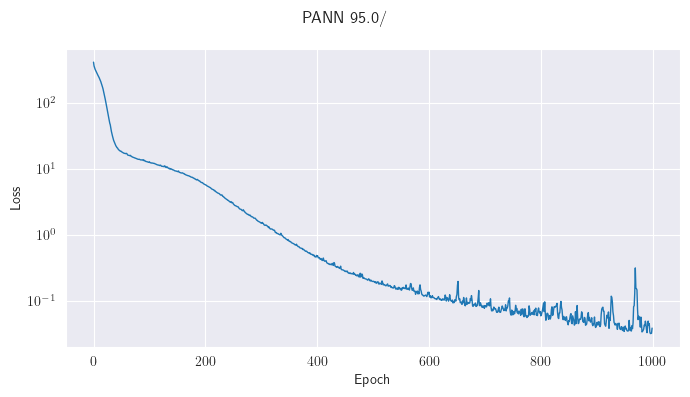

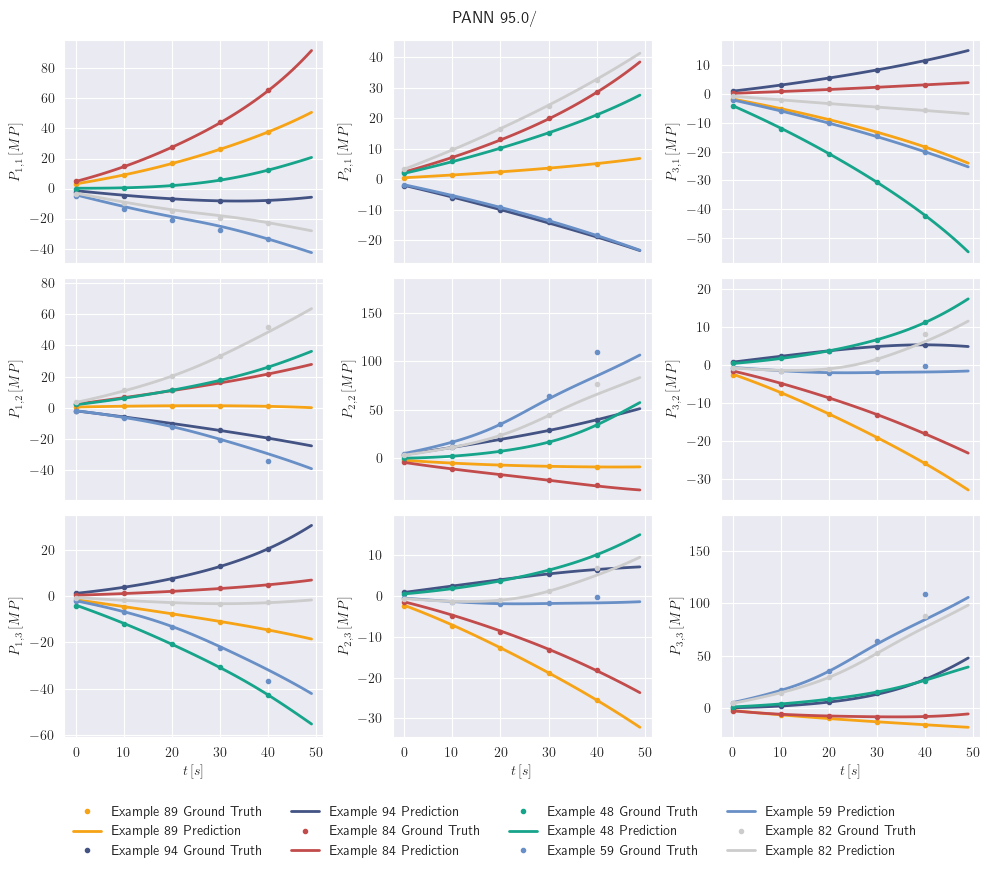

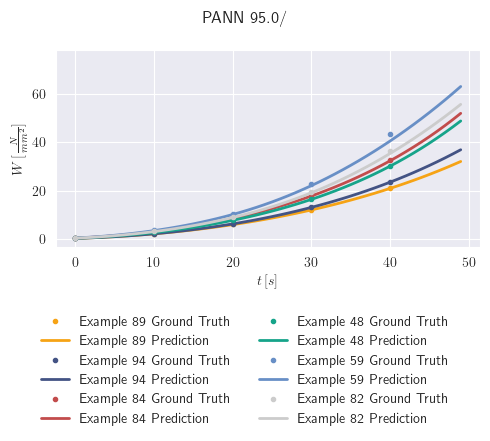

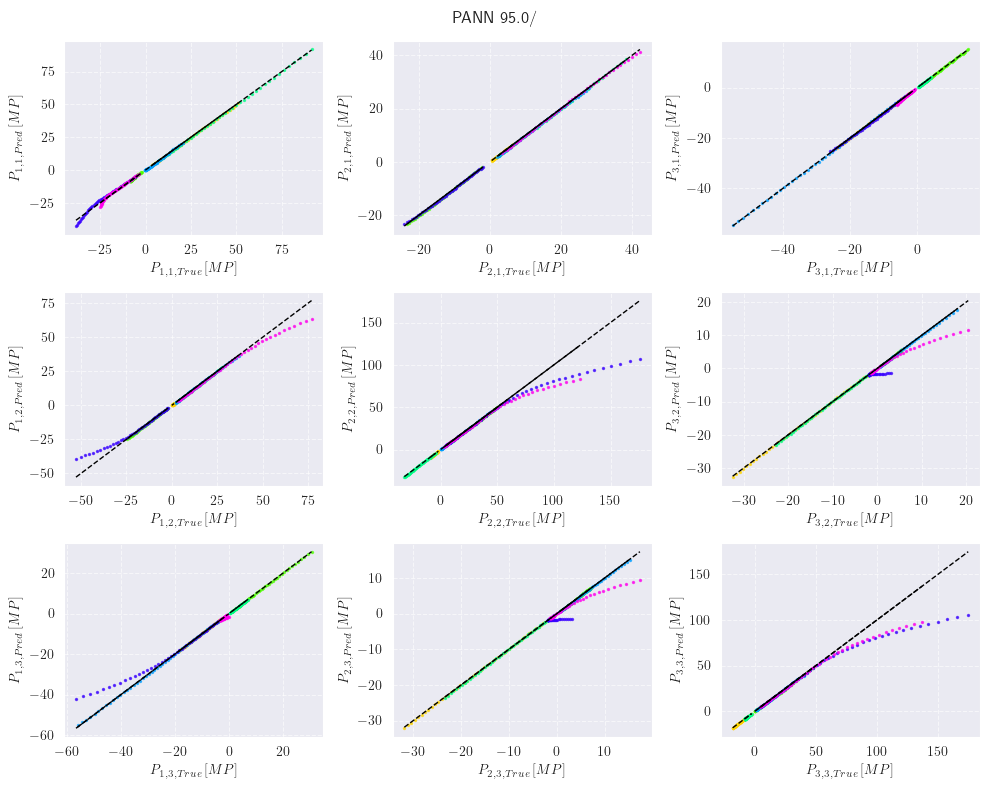

Score: 10.530367851257324
Test size of 90.0%
Naive Model...


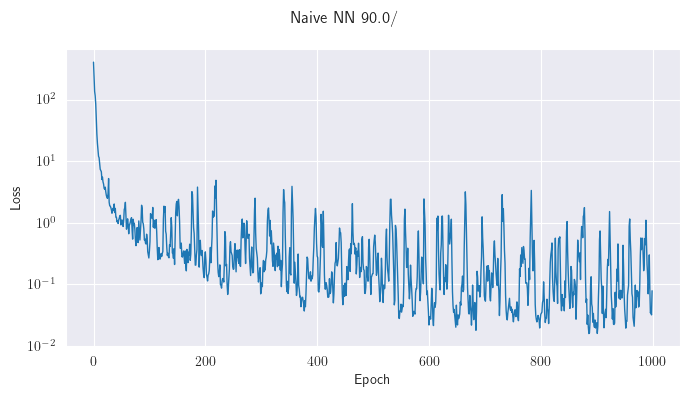

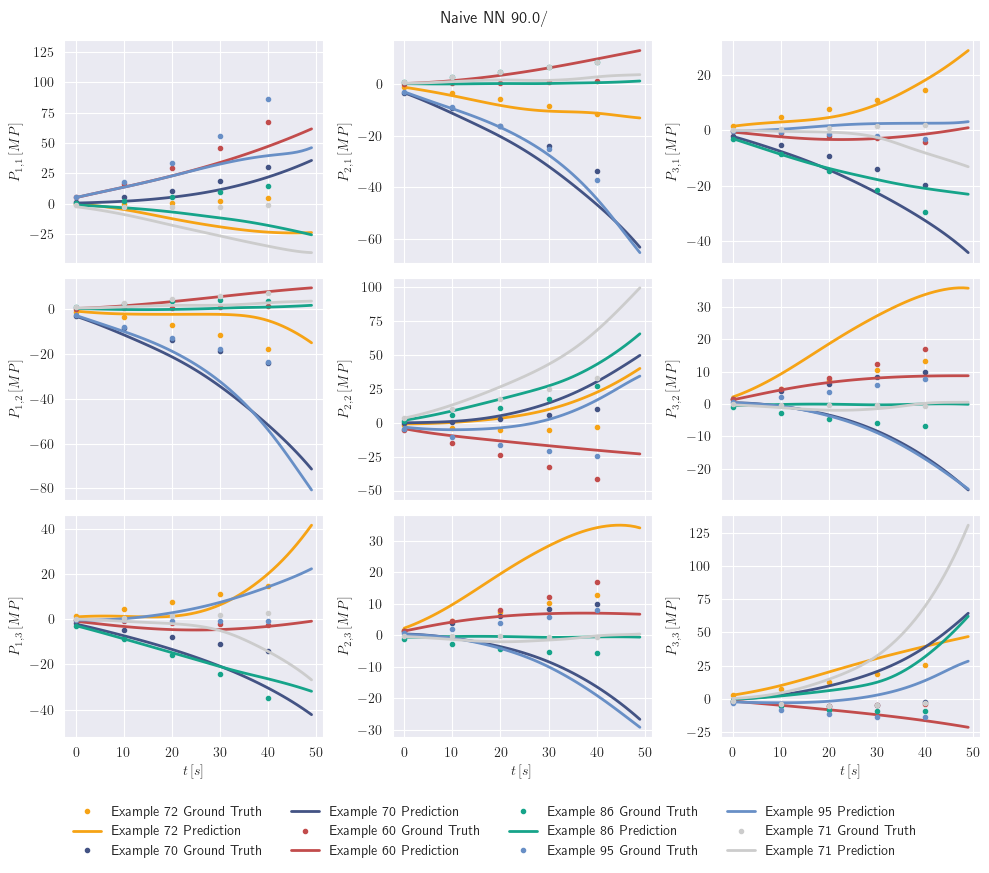

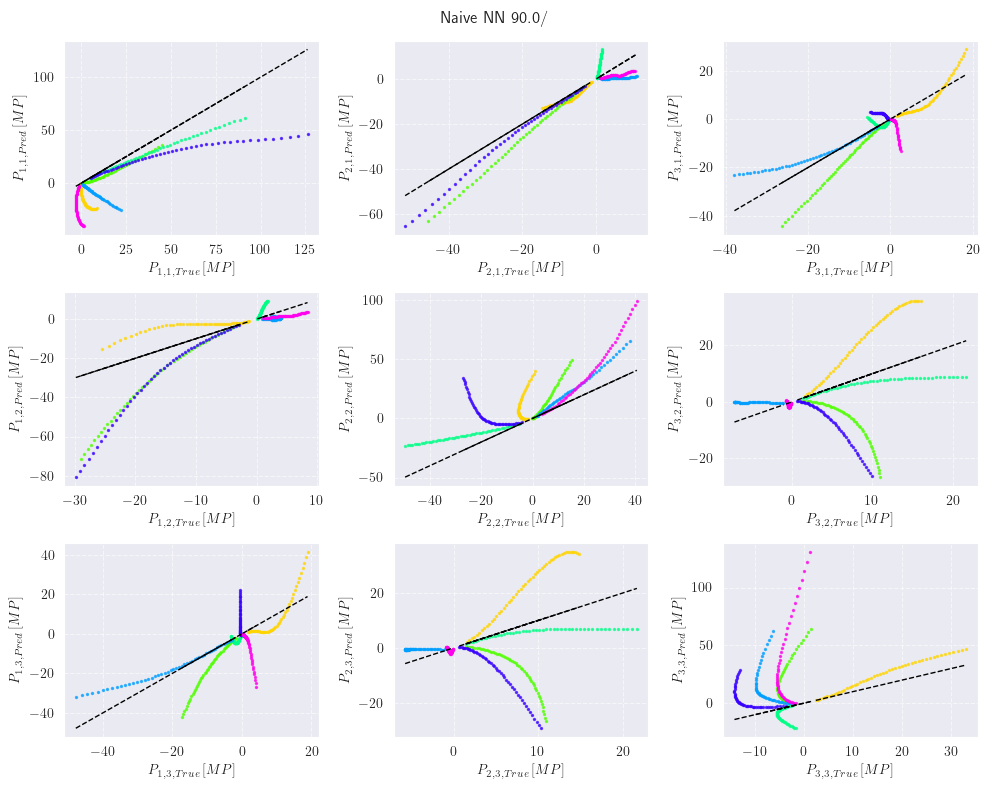

Score: 21.522445678710938
PANN Model...


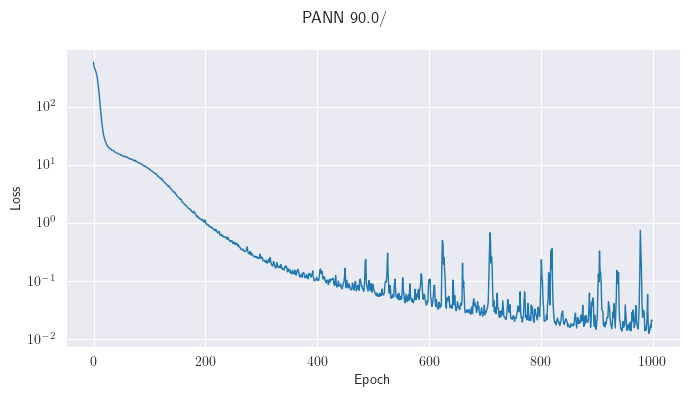

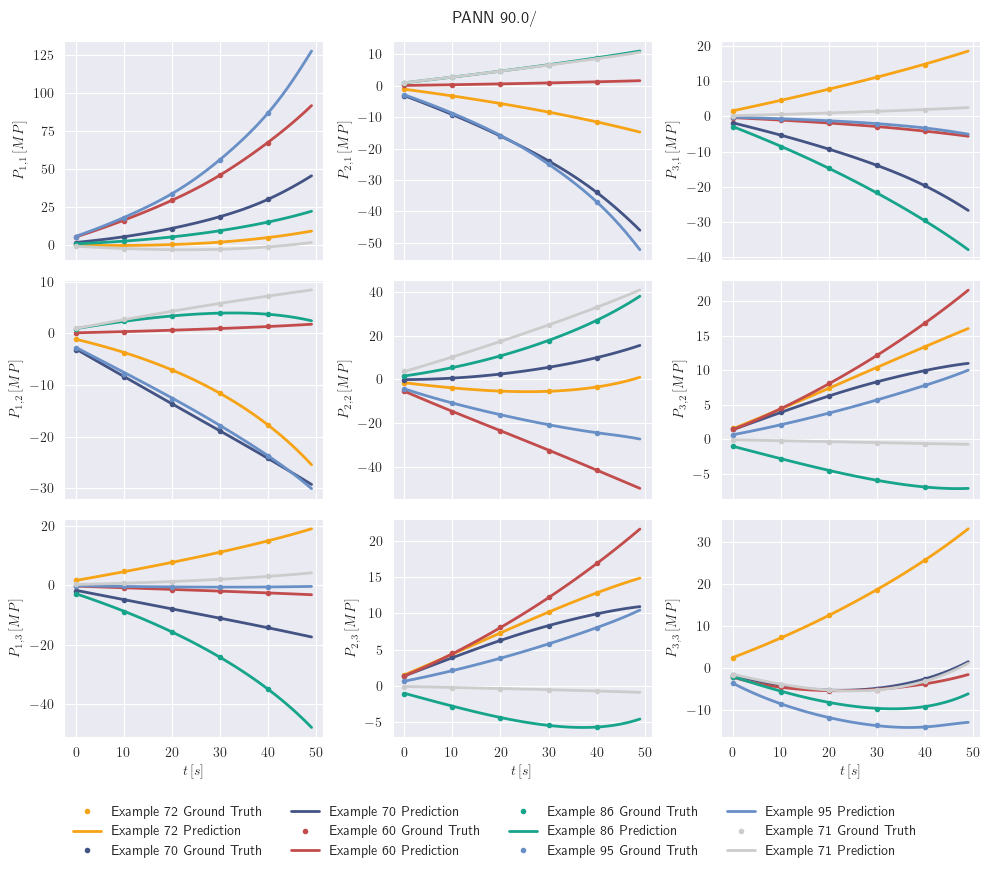

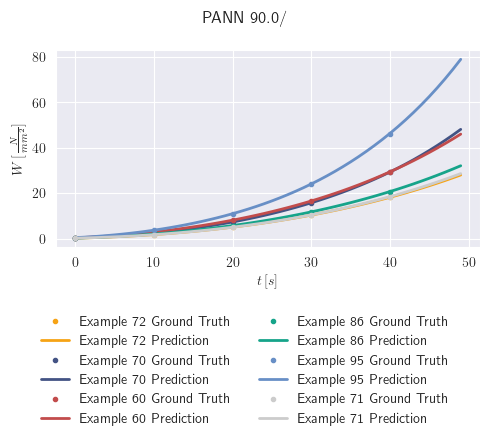

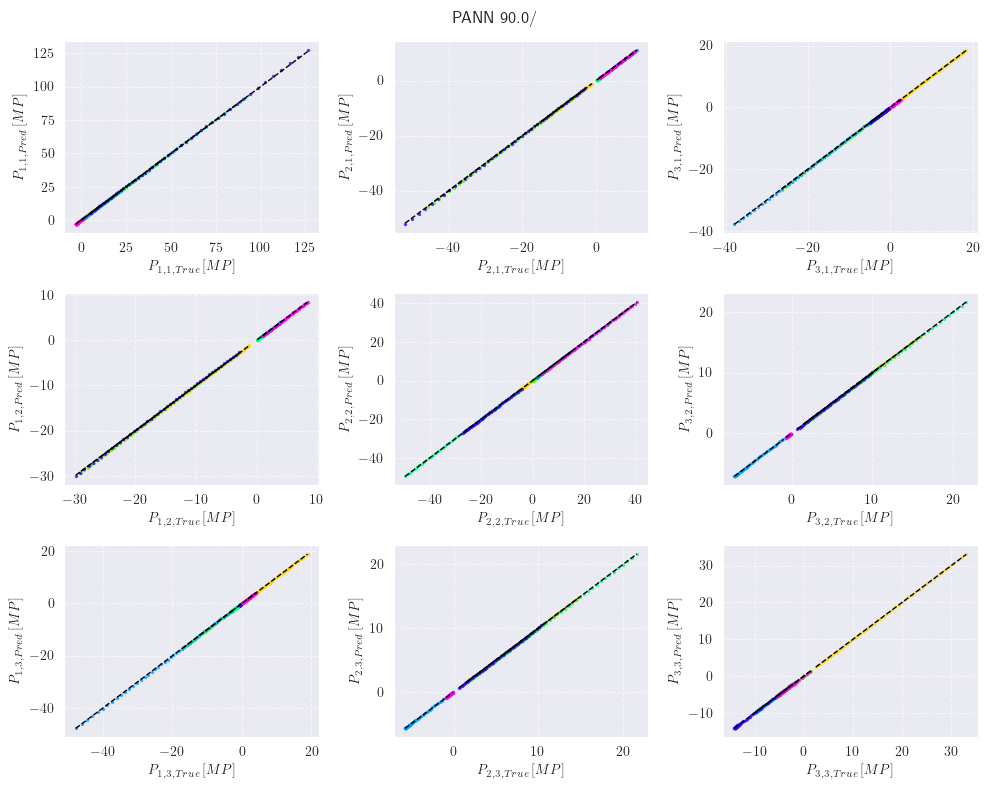

Score: 0.1842612773180008
Test size of 75.0%
Naive Model...


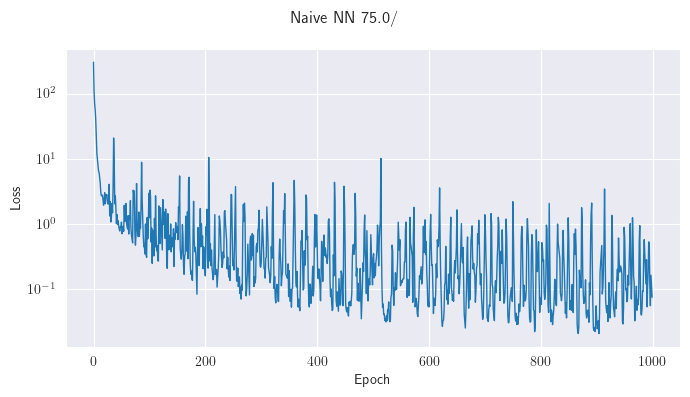

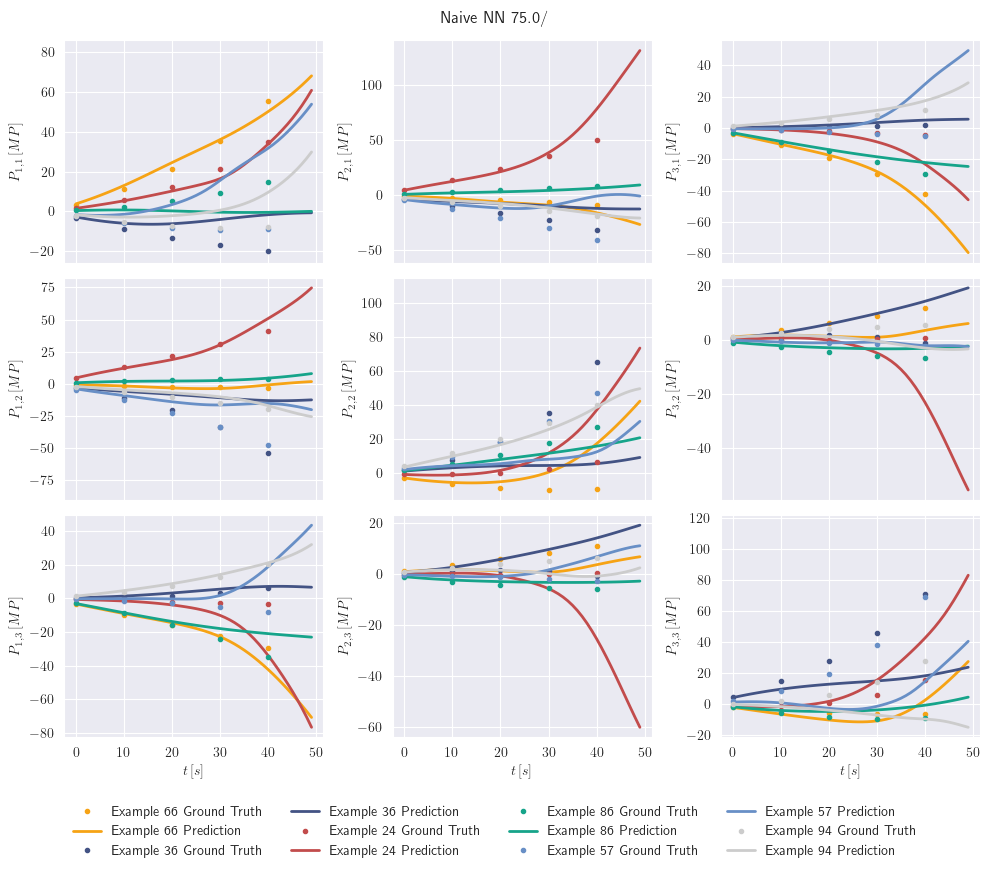

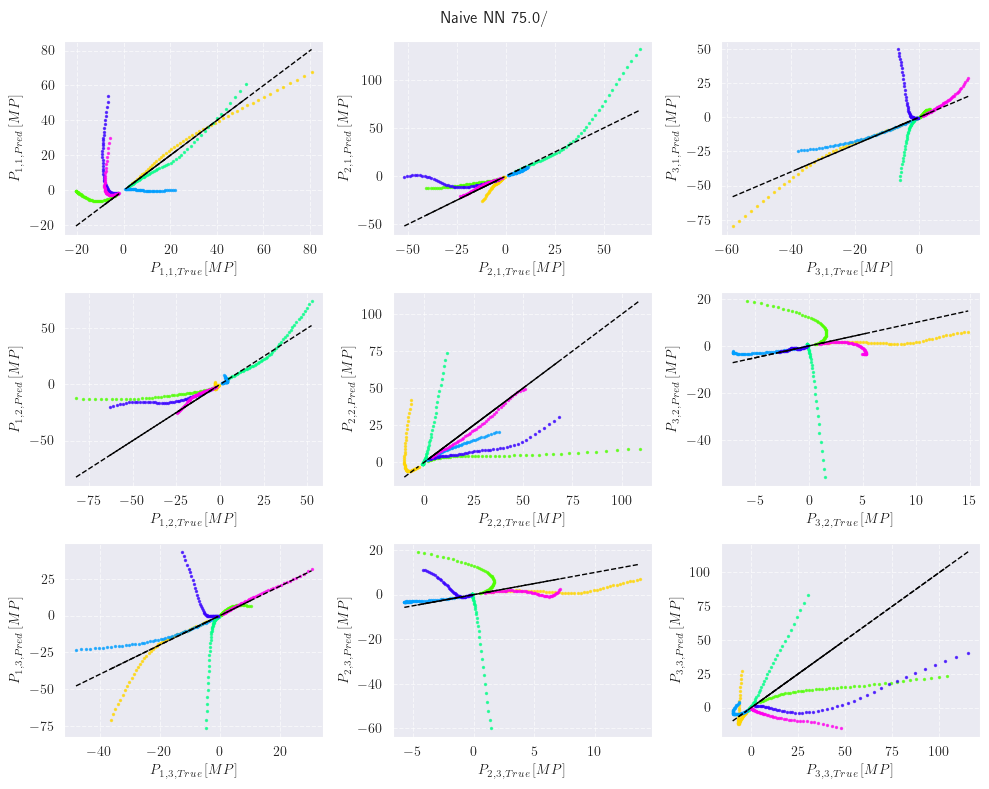

Score: 23.116018295288086
PANN Model...


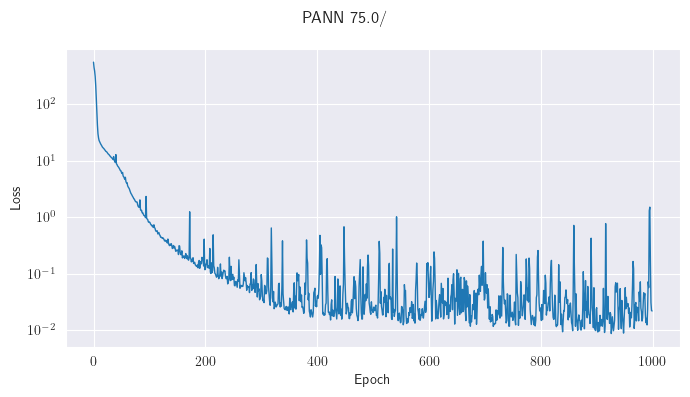

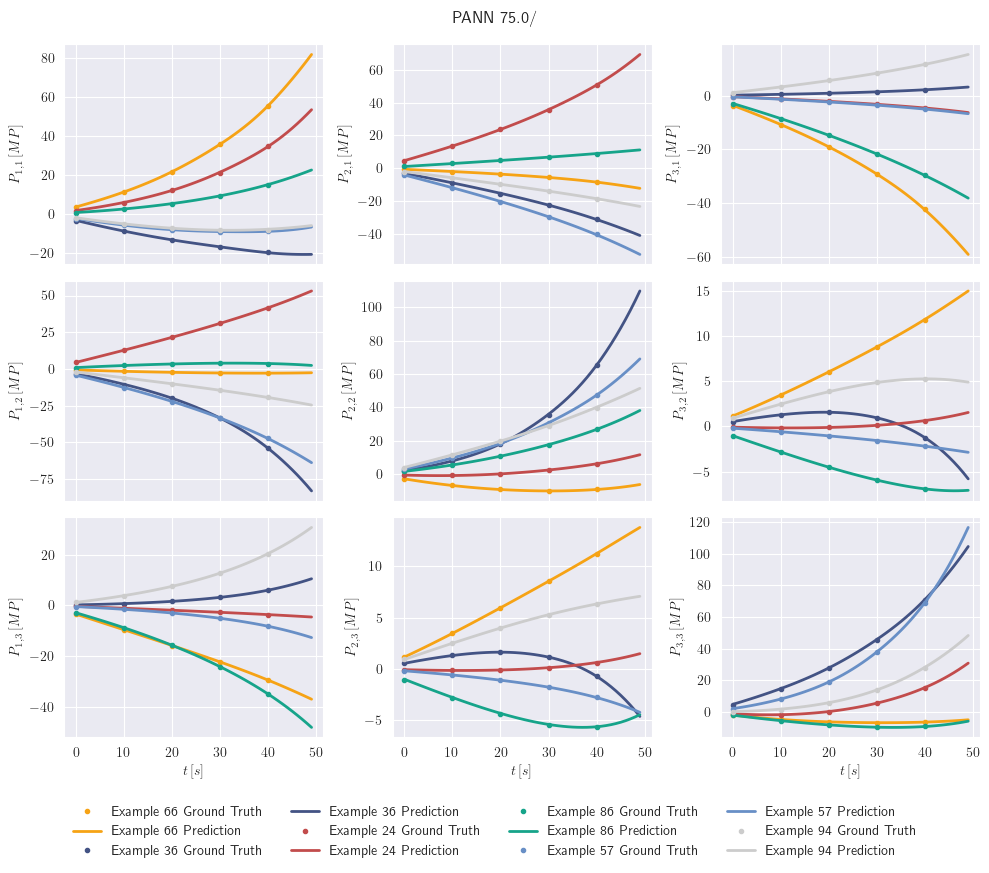

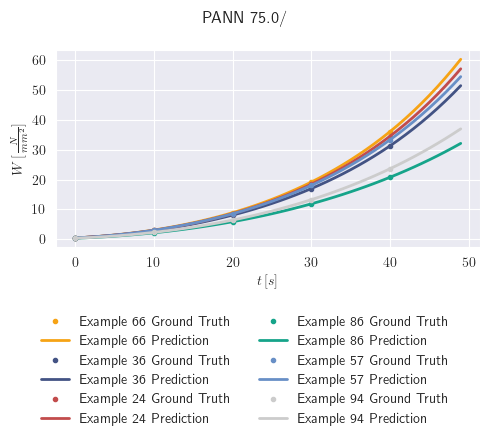

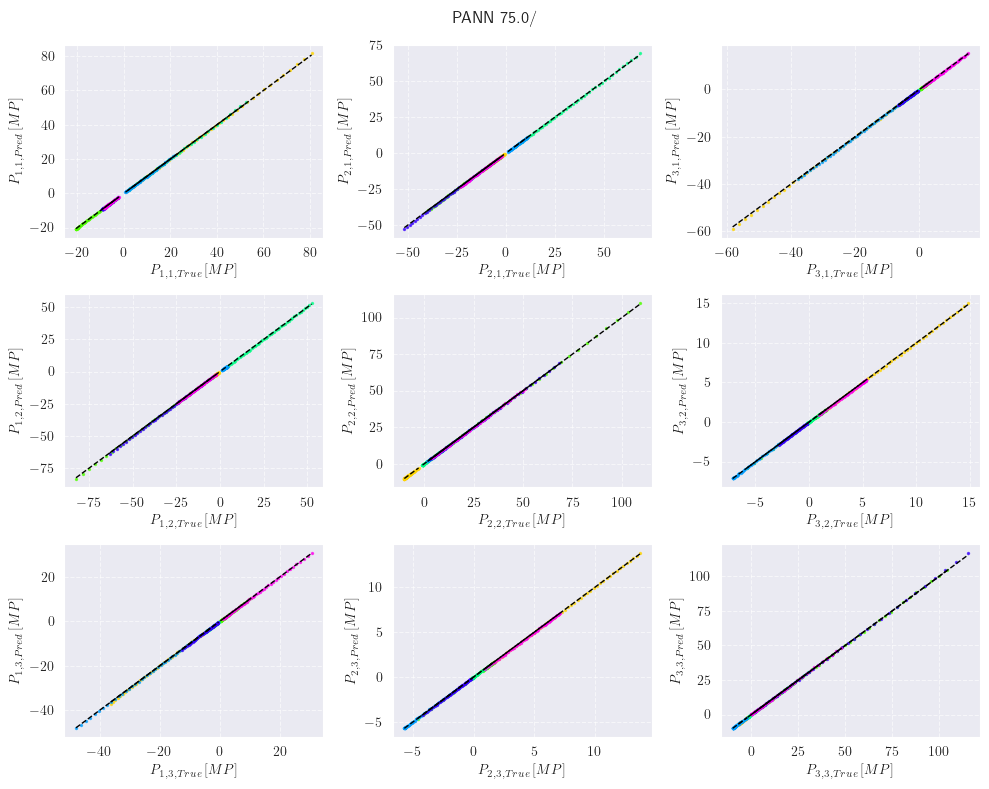

Score: 0.19541016221046448
Test size of 60.0%
Naive Model...


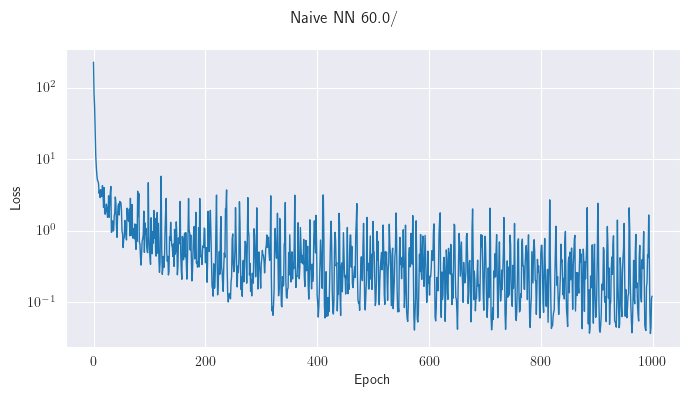

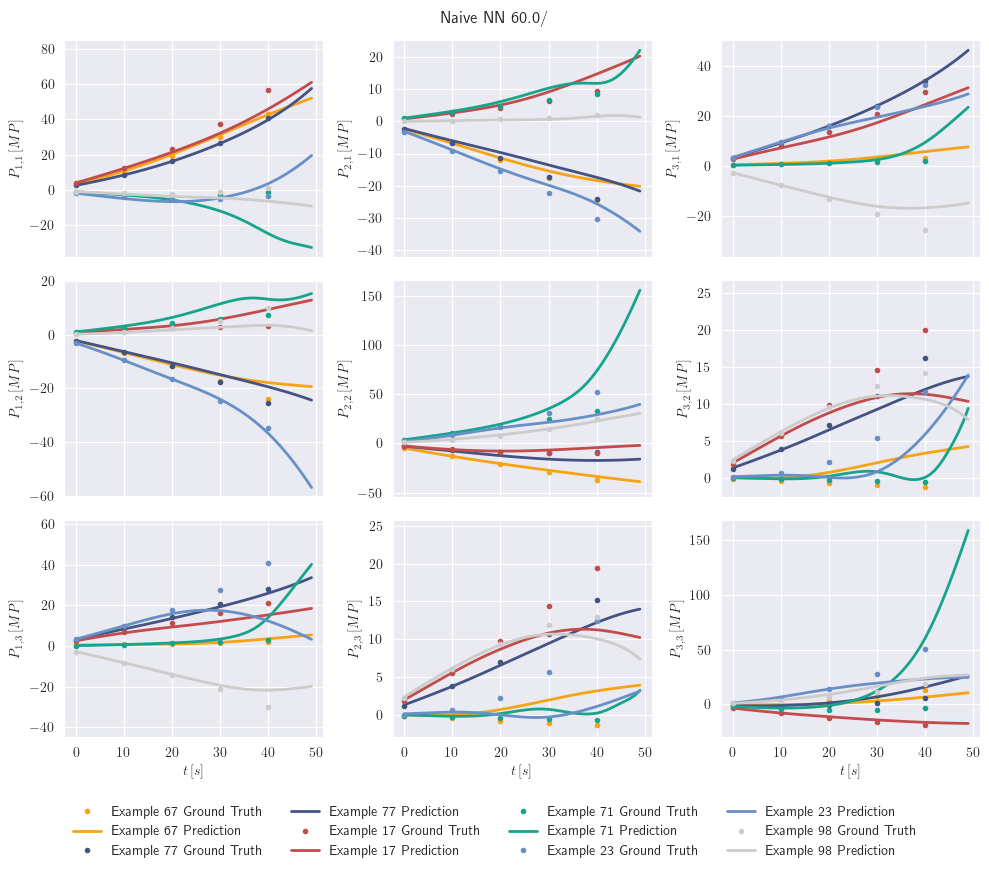

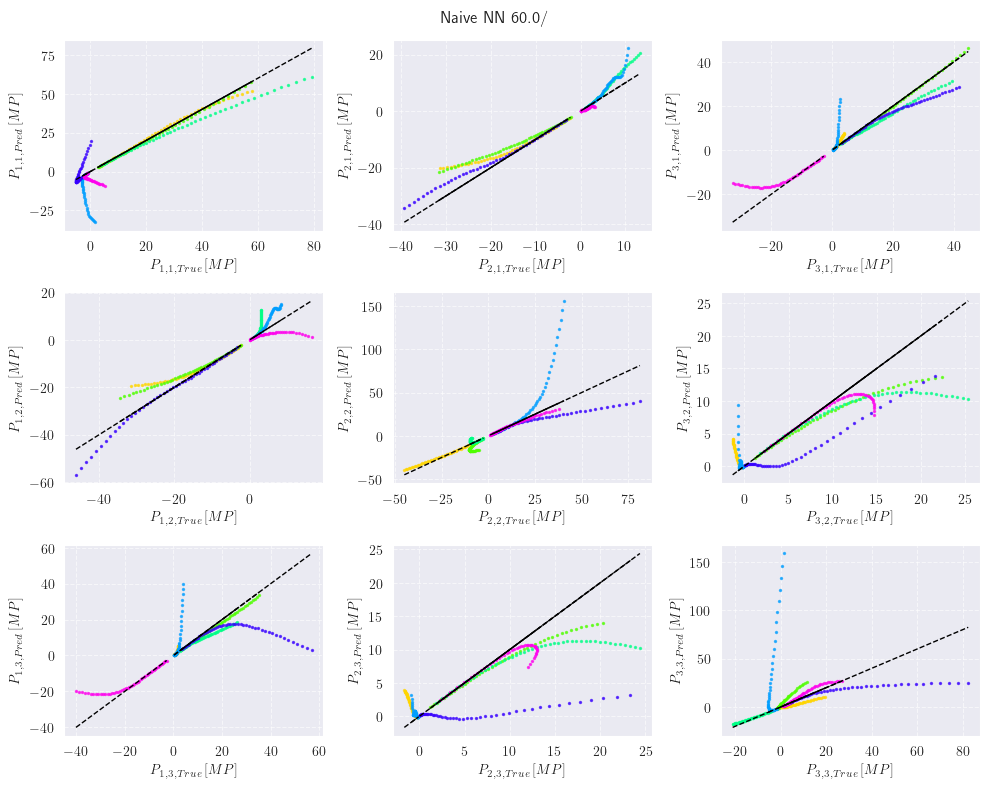

Score: 22.459627151489258
PANN Model...


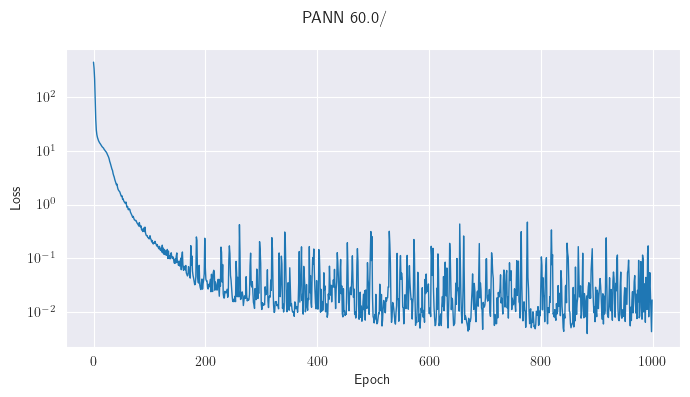

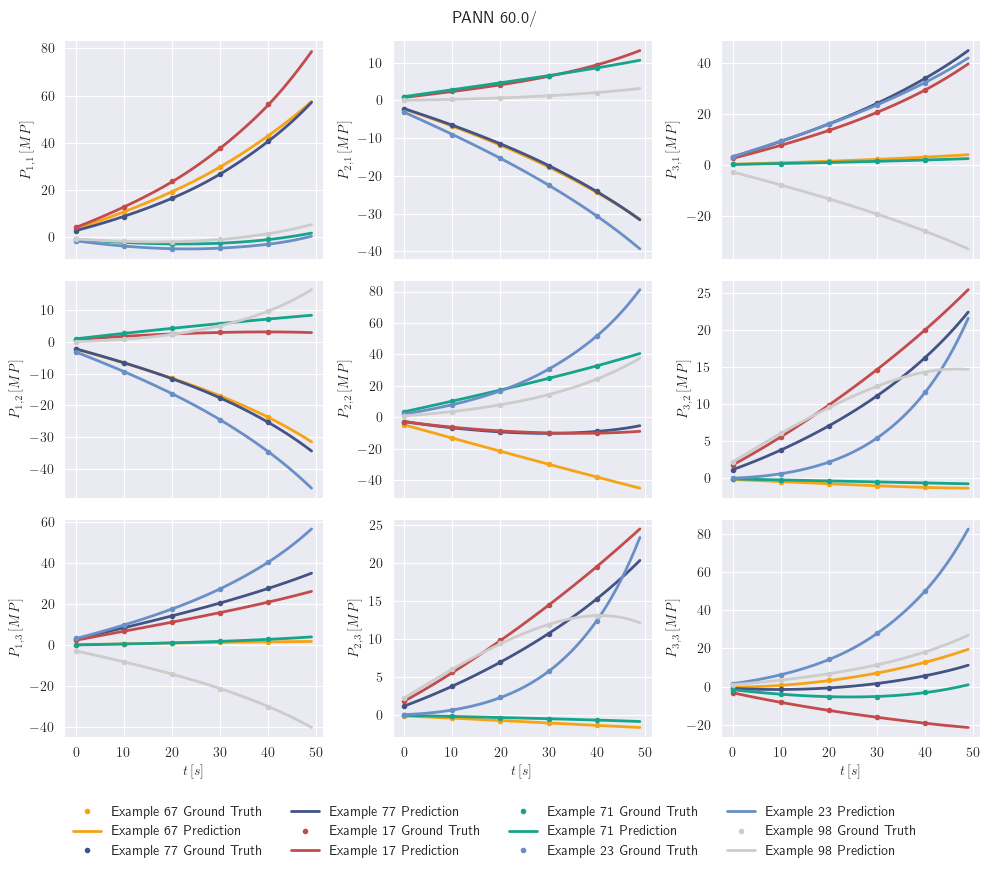

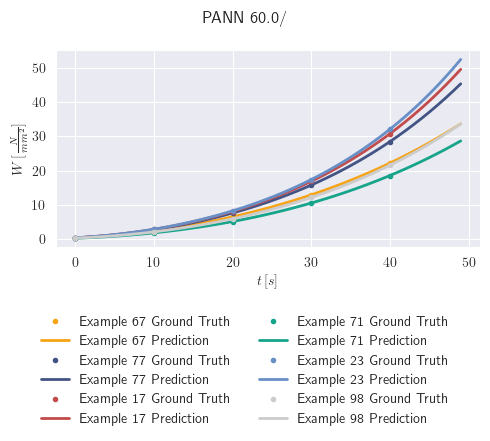

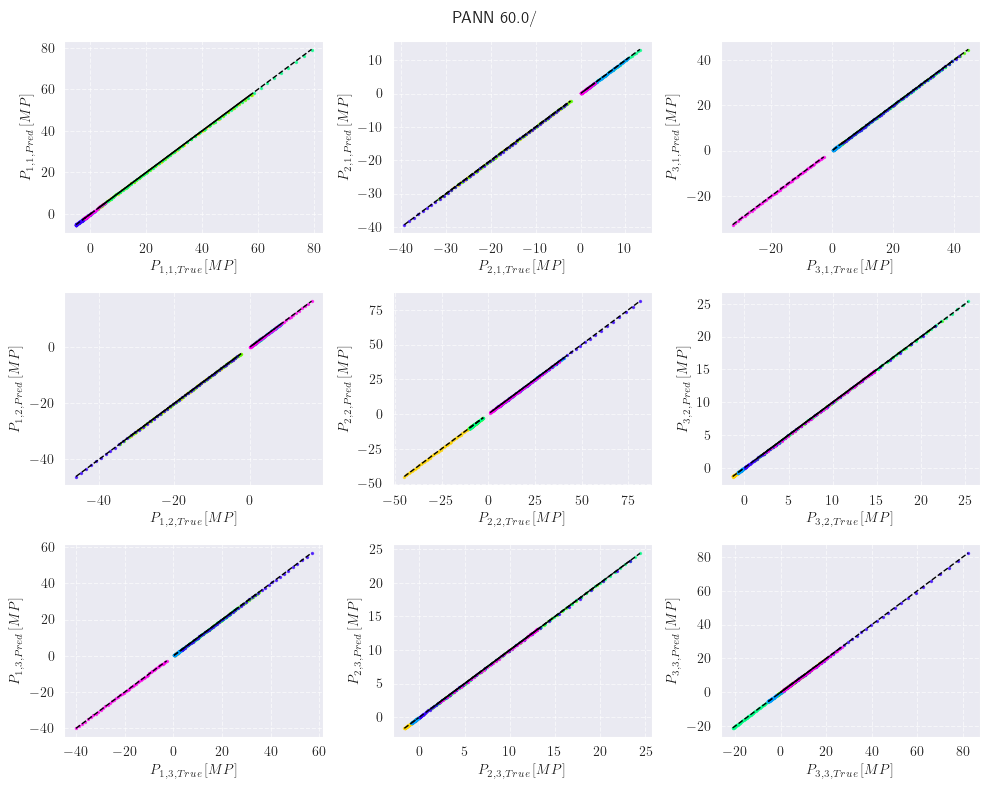

Score: 0.10008855909109116
Test size of 50.0%
Naive Model...


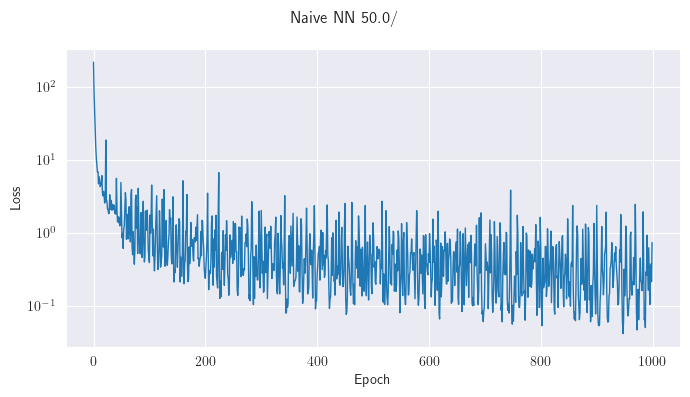

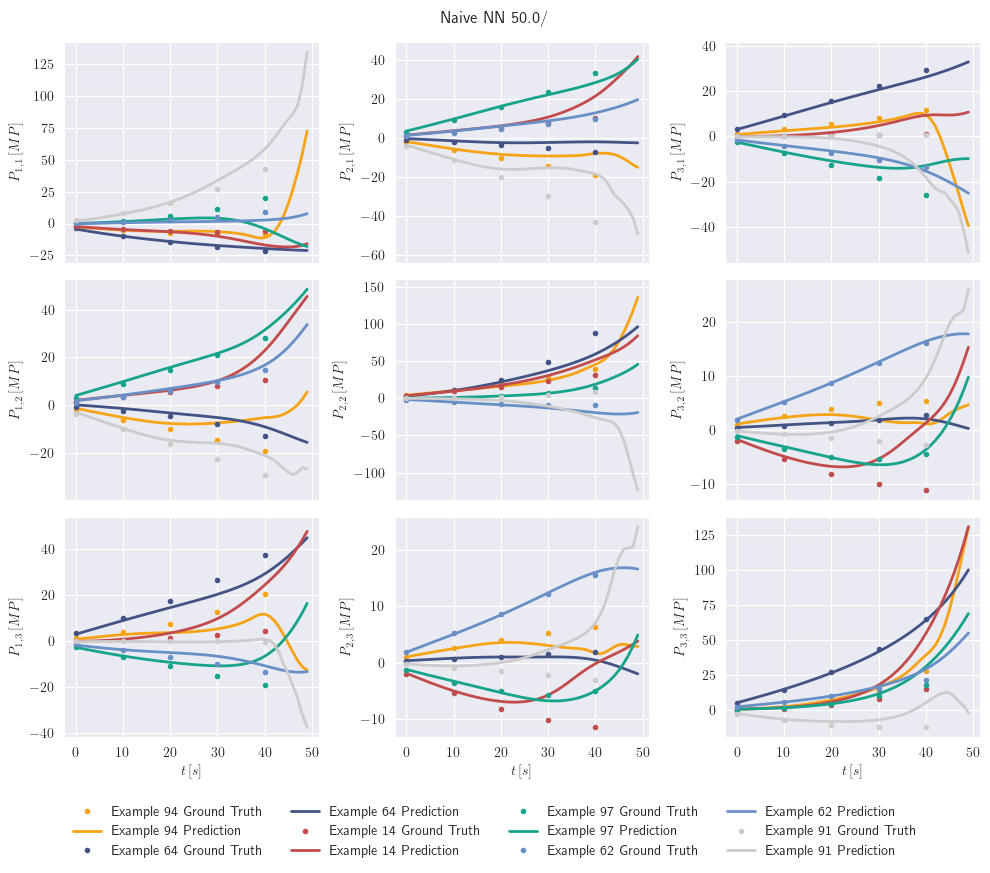

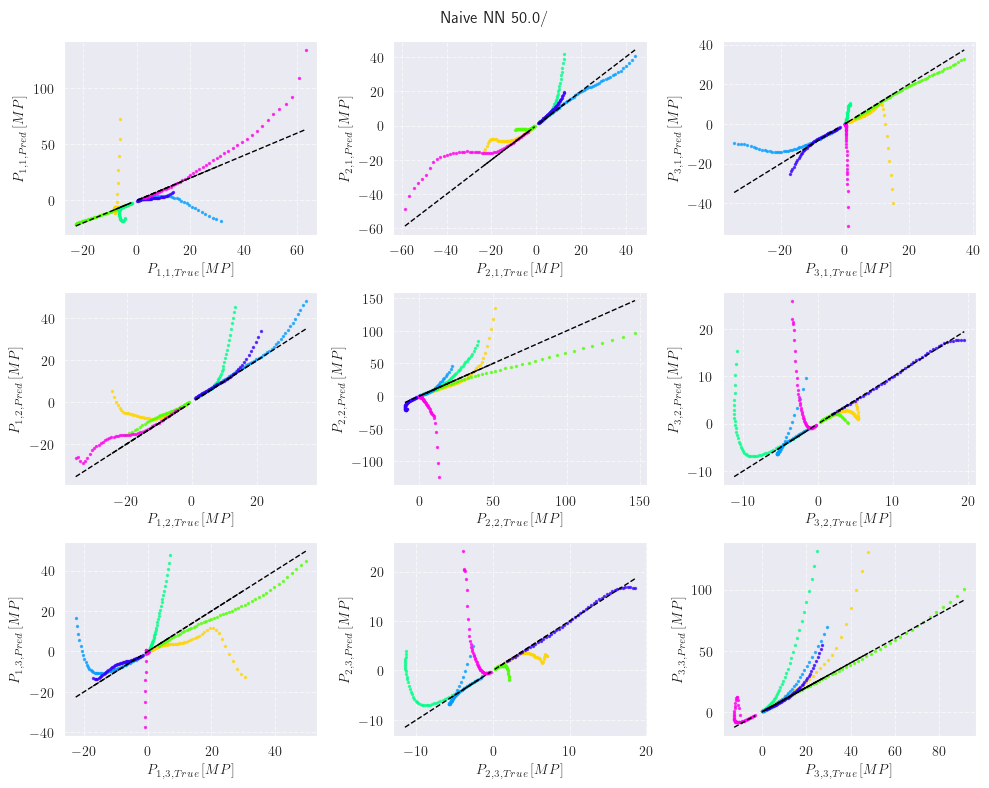

Score: 15.90457820892334
PANN Model...


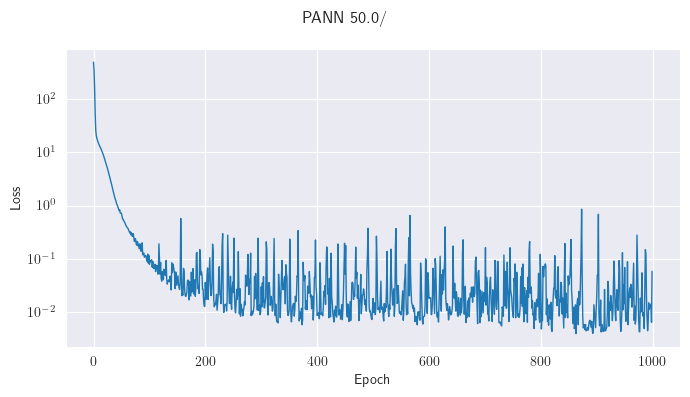

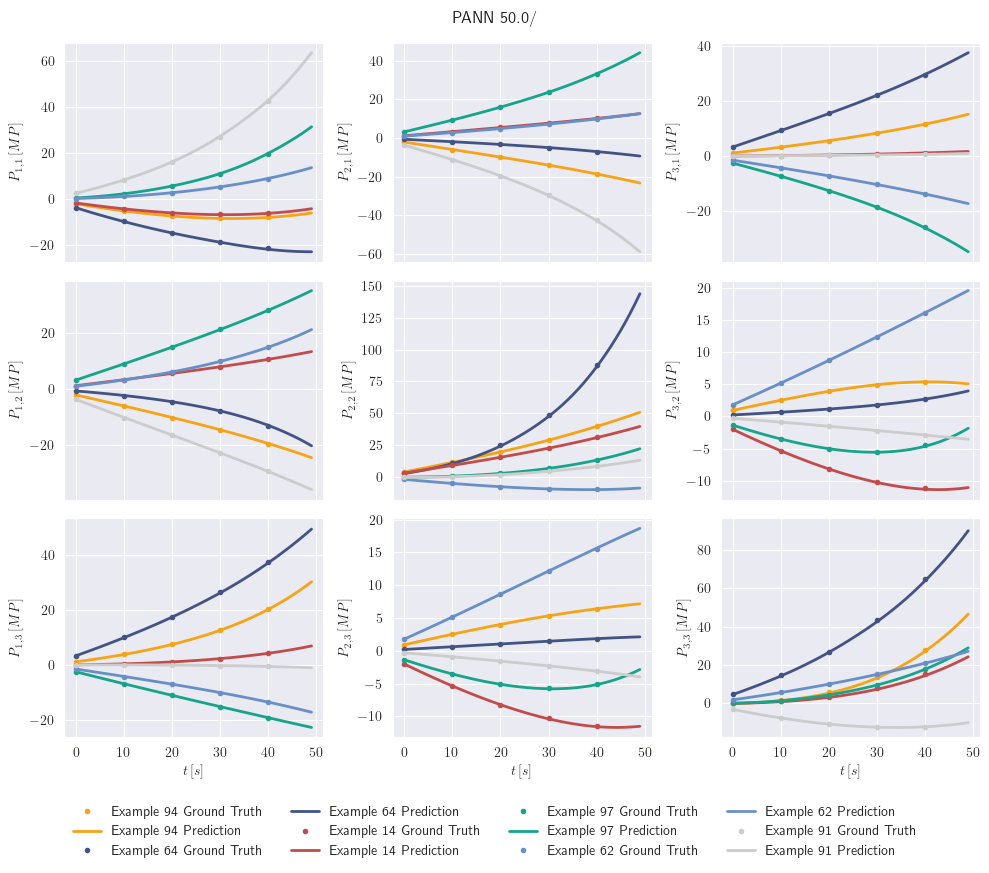

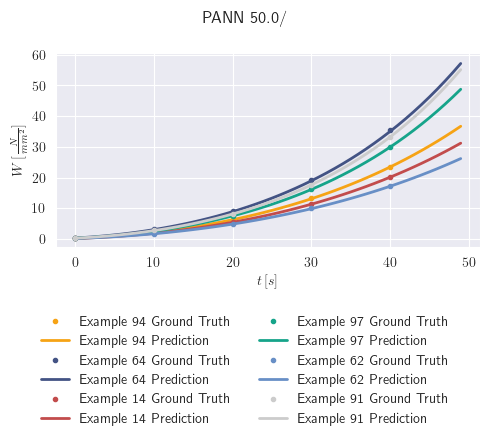

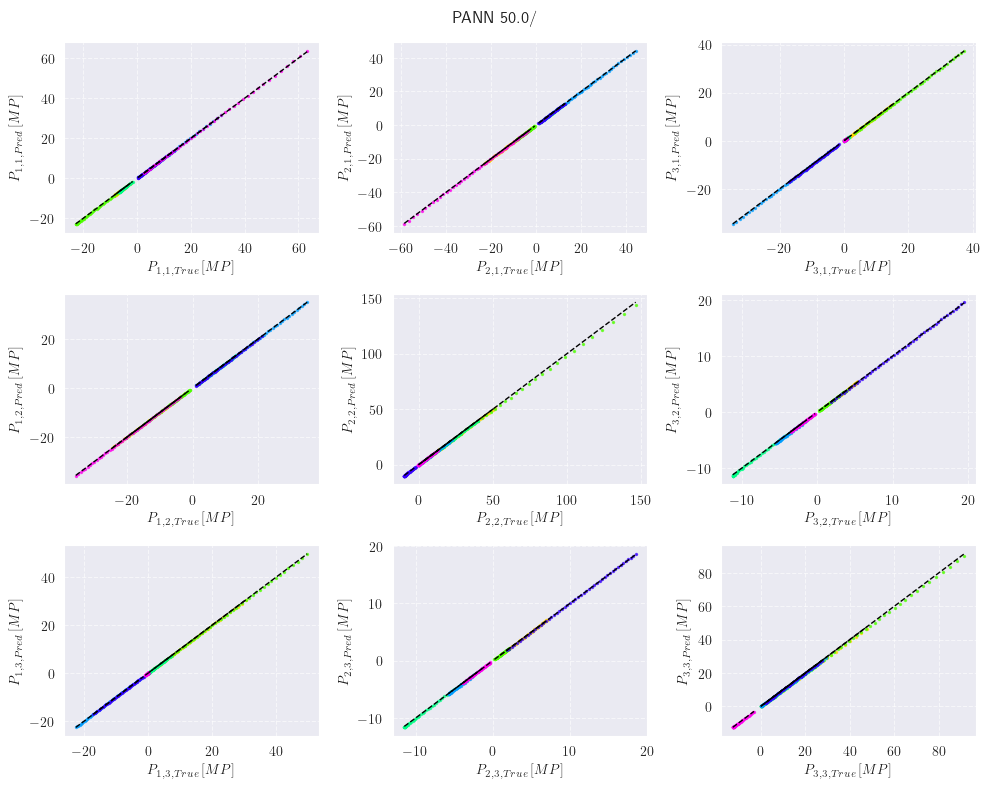

Score: 0.4864291250705719


In [6]:
for test_size in [0.95, 0.9, 0.75, 0.6, 0.5]:
    print('=' * 100)
    print(f'Test size of {test_size*100}%')
    train_data, test_data = load_train_test_concentric(data_dir, test_size=test_size)

    train_F = tf.concat([tup[0] for tup in train_data.values()], axis=0)
    train_P = tf.concat([tup[1] for tup in train_data.values()], axis=0)
    train_W = tf.concat([tup[2] for tup in train_data.values()], axis=0)

    rand_test_examples = np.random.choice(list(test_data.keys()), size=6)
    example_test_FPW_tup = {f'Example {idx}': test_data[idx] for idx in rand_test_examples}

    print('Naive Model...')
    naive_name = f'Naive NN {test_size*100}/% Testdata'
    naive_model = train_naive_model(train_F, train_P, name=naive_name)
    naive_P = predict_and_plot_naive_model(naive_model, example_test_FPW_tup, suptitle=naive_name)
    can_naive_pred = reached_good_prediction(*naive_P)

    print('PANN Model...')
    pann_name = f'PANN {test_size*100}/% Testdata'
    pann_model = train_pann_model(train_F, train_P, train_W, name=pann_name)
    pann_P = predict_and_plot_pann_model(pann_model, example_test_FPW_tup, suptitle=pann_name)
    can_pann_pred = reached_good_prediction(*pann_P)

    if can_naive_pred and can_pann_pred:
        print(f'Able to predict with a test size of {test_size}')
        break